# Getting Started

This notebook is an introduction to running the Delta-Eddington sea ice radiative transfer model in `seaicert` on ice thickness and snow depth transects collected during the MOSAiC expedition.

Snow depths were measured by Magnaprobe.  Ice thickness are measured using the GEM2 Electromagnectic resonance instrument.  Pond depths were measured using a modified Magnaprobe.  The data are available on PANGAEA.

Itkin, Polona; Webster, Melinda; Hendricks, Stefan; Oggier, Marc; Jaggi, Matthias; Ricker, Robert; Arndt, Stefanie; Divine, Dmitry V; von Albedyll, Luisa; Raphael, Ian; Rohde, Jan; Liston, Glen E (2021): Magnaprobe snow and melt pond depth measurements from the 2019-2020 MOSAiC expedition. PANGAEA, https://doi.org/10.1594/PANGAEA.937781

See the repo [README](../README.md) for requirements and installation instructions for `seaicert`.  Model, plotting and IO routines are loaded from the `src` directory.  These functions can be used to create scripts outside of the notebooks contained in the `notebooks` directory.

`matplotlib.pyplot` is used for plotting.

See `parse_data_summary_spreadsheet.ipynb` for information on downloading data and processing.

In [1]:
# Append path for src modules
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt

from mosaic_underice_sunlight.rtmodel import seaicert_mp
from mosaic_underice_sunlight.plotting import plot_results, plot_thickness_profile
from mosaic_underice_sunlight.mosaic_thickness import load_raw_combined_data, transect_distance, MAGNAPROBE_PATH

Snow depth, ice thickness and melt pond depth are in transect files in `.csv` format.  These are read into a `pandas.DataFrame`.  Here we use an example profile from 27 June 2020.  

In [2]:
def load_data(filepath):
    """Klugey fix until other transects get processed, to load raw file"""
    keep = ['lon', 'lat', 'local_x', 'local_y',
            'snow_depth_m', 'melt_pond_depth_m',
            'ice_thickness_mean_m', 'transect_distance_m']
    
    df = load_raw_combined_data(filepath)
    df['ice_thickness_mean_m'] = df['ice_thickness_18khz_ip_m']
    df['transect_distance_m'] = transect_distance(df.local_x, df.local_y)
    df['melt_pond_depth_m'] = df['melt_pond_depth_m'].where(df['melt_pond_depth_m'] > 0., 0.)
    df['snow_depth_m'] = df['snow_depth_m'].where(df['snow_depth_m'] > 0., 0.)
    df = df[keep]
    return df

In [3]:
filepath = MAGNAPROBE_PATH / '20200627-PS122-4_44-267' / 'magna+gem2-transect-20200627_PS122-4_44-267_transect.csv'
df = load_data(filepath)
df.head()

,lon,lat,local_x,local_y,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,transect_distance_m
Date/Time,,,,,,,,
2020-06-27 11:22:46,9.89478,81.95278,-153.212507,-73.419080,0.05502,0.0,3.521437,0.000000
2020-06-27 11:22:55,9.89510,81.95277,-157.810002,-70.192152,0.05277,0.0,3.667773,5.616941
2020-06-27 11:23:09,9.89550,81.95272,-161.934210,-66.335585,0.09930,0.0,3.426157,11.263374
2020-06-27 11:23:17,9.89592,81.95270,-164.498767,-58.848335,0.09980,0.0,2.872571,19.177656
2020-06-27 11:23:24,9.89624,81.95268,-168.702058,-53.028117,0.06230,0.0,3.049500,26.356972


The following plot shows ice thickness (light-blue), snow depth (grey) and pond depth (dark blue) for the ~1300 m transect.  Ice thickness, and snow and pond depth are shown relative to the ice surface.

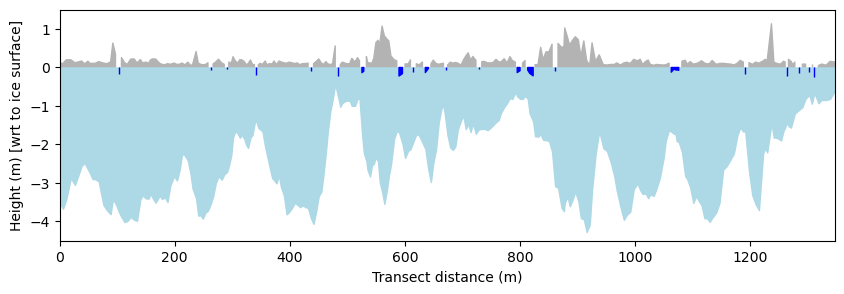

In [4]:
fig, ax = plt.subplots(figsize=(10,3))
plot_thickness_profile(df, ax=ax)  # Add legend and axis title with units

The radiative transfer model is a single column model.  `seaice_rt` is a helper function that takes a `pandas.DataFrame` containing snow depth, pond depth and ice thickness along a transect and returns radiative fluxes, surface alebdo etc along the transect.

In [5]:
%%time
rt_df = seaicert_mp(df)
rt_df.head()

CPU times: user 275 ms, sys: 21.9 ms, total: 297 ms
Wall time: 261 ms


,datetime,latitude,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,sw_absorbed_by_ocean,downwelling_radiative_flux_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,transect_distance_m,par_absorbed_by_ocean
transect_distance_m,,,,,,,,,,,
0.000000,2020-06-27 11:22:46,81.95278,0.05502,0.0,3.521437,0.256733,0.256733,0.848763,361.213745,0.000000,0.898566
5.616941,2020-06-27 11:22:55,81.95277,0.05277,0.0,3.667773,0.223884,0.223884,0.847527,360.627350,5.616941,0.783593
11.263374,2020-06-27 11:23:09,81.95272,0.09930,0.0,3.426157,0.170409,0.170409,0.862632,367.934998,11.263374,0.596432
19.177656,2020-06-27 11:23:17,81.95270,0.09980,0.0,2.872571,0.318801,0.318801,0.862701,367.969910,19.177656,1.115803
26.356972,2020-06-27 11:23:24,81.95268,0.06230,0.0,3.049500,0.399520,0.399520,0.852221,362.867432,26.356972,1.398322


A helper function `plot_results` does what it says on the tin. 

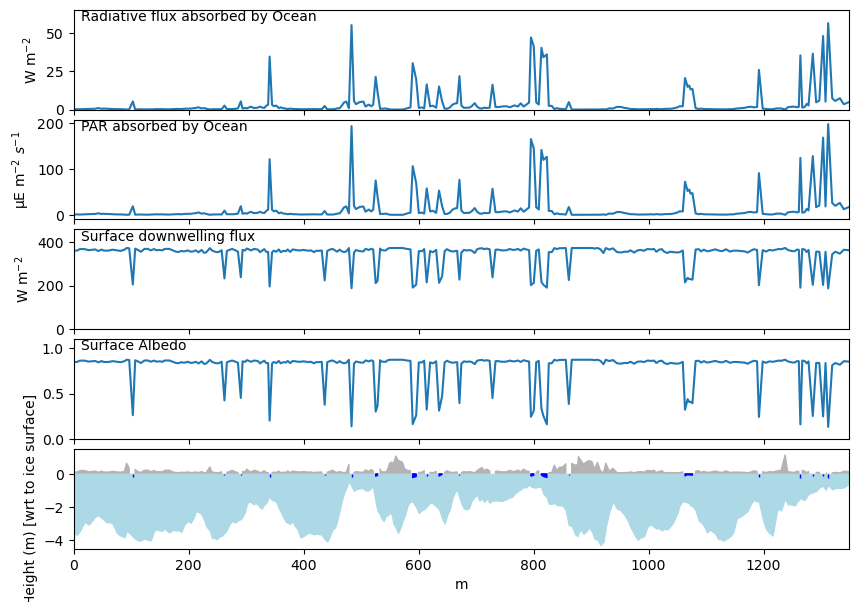

In [6]:
plot_results(rt_df)

In [11]:
rt_df.to_csv(filepath.name.replace(".csv", ".deflux.csv"))